In [1]:
from __future__ import division
import argparse
import math
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import pickle
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

### Model Construction

In [92]:
class RNN(nn.Module):
    def __init__(self, epochs=5, batchsize=50, vocabsize=5, embsize=100):
        super(RNN, self).__init__()
        self.epochs = 5
        self.batchsize = batchsize
        self.vocabsize = vocabsize
        self.embsize = embsize

        self.emb_icd = nn.Linear(vocabsize_icd, embsize_icd)
        self.emb_meds = nn.Linear(vocabsize_meds, embsize_meds)
        self.emb_labs = nn.Linear(vocabsize_labs, embsize_labs)

        self.rnn = nn.LSTM(input_size=embsize, hidden_size=embsize, num_layers=1)
        self.out = nn.Linear(embsize, 1)
        self.sig = nn.Sigmoid()

    def forward(self, input_icd, input_med, input_lab, input_latent, hidden=None, force=True, steps=0):
        if force or steps == 0: steps = len(input_icd)
        outputs = Variable(torch.zeros(steps, 1, 1))

        input_icd = self.emb_icd(input_icd)
        input_med = self.emb_meds(input_med)
        input_lab = self.emb_labs(input_lab)

        inputs = F.relu(torch.cat((input_icd, input_med, input_lab, input_latent),1))

        inputs = inputs.view(inputs.size()[0],1,inputs.size()[1])
        outputs, hidden = self.rnn(inputs, hidden)
        outputs = self.out(outputs)
        return outputs.squeeze(), hidden

    def predict(self, input_icd, input_med, input_lab, input_latent):
        out, hid = self.forward(input_icd, input_med, input_lab, input_latent, None)
        return self.sig(out[-1]).data

### Data import

In [93]:
DATA_PATH = 'E:/CS_Master_Degree_UIUC/CS598_DeepLearning_for_Health_Data/Project/paper290/MIMIC_Processed/'
CAE_PATH = 'E:/CS_Master_Degree_UIUC/CS598_DeepLearning_for_Health_Data/Project/paper290/Output/'

In [95]:
n_epochs = 1
vocabsize_icd = 942
vocabsize_meds = 3202
vocabsize_labs = 284 #all 681
vocabsize = vocabsize_icd+vocabsize_meds+vocabsize_labs

embsize_icd = 50
embsize_meds = 75
embsize_labs = 50
embsize_latent = 175
embsize = embsize_icd + embsize_labs + embsize_meds + embsize_latent

input_seqs_icd = pickle.load(open(DATA_PATH + 'MIMICIIIPROCESSED.3digitICD9.seqs', 'rb'))
input_seqs_meds = pickle.load(open(DATA_PATH + 'MIMICIIIPROCESSED.meds.seqs', 'rb'))
input_seqs_labs = pickle.load(open(DATA_PATH + 'MIMICIIIPROCESSED.abnlabs.seqs', 'rb'))
input_seqs_fullicd = pickle.load(open(DATA_PATH + 'MIMICIIIPROCESSED.seqs', 'rb'))

input_seqs_latent = pickle.load(open(CAE_PATH + 'CAE_Embeddings.seqs', 'rb'))
# latent_weights = pickle.load(open(args.emb_weights))
CAE_emb_weights = torch.tensor(np.load(CAE_PATH + 'CAE_embedding_weights.npy',allow_pickle=True))
print(CAE_emb_weights.size())

labels = pickle.load(open(DATA_PATH + 'MIMICIIIPROCESSED.morts', 'rb'))

torch.Size([4428, 175])


In [96]:
input_seqs_latent.shape

torch.Size([7537, 175])

### Model Training

In [101]:
print('Data loaded..')

trainratio = 0.7
validratio = 0.1
testratio = 0.2

trainlindex = int(len(input_seqs_icd)*trainratio)
validlindex = int(len(input_seqs_icd)*(trainratio + validratio))

# Some functions that will be used during training for input seq conversion to one hot vector and the correlation calculation
def convert_to_one_hot(code_seqs, len_):
    new_code_seqs = []
    for code_seq in code_seqs:
        one_hot_vec = np.zeros(len_)
        for code in code_seq:
            one_hot_vec[code] = 1
        new_code_seqs.append(one_hot_vec)
    return np.array(new_code_seqs)

def get_avg(seqs, type_):
    count = 0
    for seq in seqs:
        count += len(seq)
    val = round(count*1.0/len(seqs))
    if type_ == 'i':
        return min(4, int(val/5))
    else:
        return min(4, int(val/50))

Data loaded..


In [102]:
import time

start = time.process_time()

print('Starting training..')

batchsize = 50

# ICD_wise_tot_tr = np.zeros(5)
# meds_wise_tot_tr = np.zeros(5)
# labs_wise_tot_tr = np.zeros(5)

# for i in range(len(train_input_seqs_icd)):
# 	ICD_wise_tot_tr[get_avg(train_input_seqs_icd[i], 'i')] += 1
# 	meds_wise_tot_tr[get_avg(train_input_seqs_meds[i], 'm')] += 1
# 	labs_wise_tot_tr[get_avg(train_input_seqs_labs[i], 'l')] += 1

# print 'ICD-wise train total', ICD_wise_tot_tr
# print 'Meds-wise train total', meds_wise_tot_tr
# print 'Labs-wise train total', labs_wise_tot_tr

best_aucrocs = []
for run in range(10):
    print('Run', run)

    perm = np.random.permutation(len(input_seqs_icd))
    rinput_seqs_icd = [input_seqs_icd[i] for i in perm]
    rinput_seqs_meds = [input_seqs_meds[i] for i in perm]
    rinput_seqs_labs = [input_seqs_labs[i] for i in perm]
    rinput_seqs_latent = input_seqs_latent[perm]
    rinput_seqs_fullicd = [input_seqs_fullicd[i] for i in perm]
    rlabels = [labels[i] for i in perm]
    rlabels = torch.tensor(rlabels)
    
    train_input_seqs_icd = rinput_seqs_icd[:trainlindex]
    train_input_seqs_meds = rinput_seqs_meds[:trainlindex]
    train_input_seqs_labs = rinput_seqs_labs[:trainlindex]
    train_input_seqs_latent = rinput_seqs_latent[:trainlindex]
    train_labels = rlabels[:trainlindex]
    train_labels = train_labels.reshape(train_labels.shape[0],1)

    valid_input_seqs_icd = rinput_seqs_icd[trainlindex:validlindex]
    valid_input_seqs_meds = rinput_seqs_meds[trainlindex:validlindex]
    valid_input_seqs_labs = rinput_seqs_labs[trainlindex:validlindex]
    valid_input_seqs_latent = rinput_seqs_latent[trainlindex:validlindex]
    valid_labels = rlabels[trainlindex:validlindex]

    test_input_seqs_icd = rinput_seqs_icd[validlindex:]
    test_input_seqs_meds = rinput_seqs_meds[validlindex:]
    test_input_seqs_labs = rinput_seqs_labs[validlindex:]
    test_input_seqs_latent = rinput_seqs_latent[validlindex:]
    test_input_seqs_fullicd = rinput_seqs_fullicd[validlindex:]
    test_labels = rlabels[validlindex:]

    n_iters = len(train_input_seqs_icd)

    model = RNN(n_epochs, 1, vocabsize, embsize)
    criterion = nn.BCEWithLogitsLoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    aucrocs = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        print('Epoch', (epoch+1))

        for i in (range(0, n_iters, batchsize)):
            
            batch_icd = train_input_seqs_icd[i:i+batchsize]
            batch_meds = train_input_seqs_meds[i:i+batchsize]
            batch_labs = train_input_seqs_labs[i:i+batchsize]
            batch_latent = train_input_seqs_latent[i:i+batchsize]

            batch_train_labels = train_labels[i:i+batchsize]

            optimizer.zero_grad()
            losses = []

            for j in range(len(batch_icd)):
                icd_onehot = convert_to_one_hot(batch_icd[j], vocabsize_icd)
                med_onehot = convert_to_one_hot(batch_meds[j], vocabsize_meds)
                lab_onehot = convert_to_one_hot(batch_labs[j], vocabsize_labs)

                icd_inputs = Variable(torch.from_numpy(icd_onehot).float())
                med_inputs = Variable(torch.from_numpy(med_onehot).float())
                lab_inputs = Variable(torch.from_numpy(lab_onehot).float())
                
                latent_inputs_oh = np.concatenate((icd_onehot, med_onehot, lab_onehot), 1)
                latent_inputs = np.dot(latent_inputs_oh, CAE_emb_weights)
                latent_inputs = Variable(torch.from_numpy(latent_inputs).float())
                # latent_inputs = Variable(batch_latent[j].float())


                targets = Variable(batch_train_labels[j].float())

                # Use teacher forcing 50% of the time
                force = random.random() < 0.5
                outputs, hidden = model(icd_inputs, med_inputs, lab_inputs, latent_inputs, None, force)
                
                #print outputs[-1], targets
                loss = criterion(outputs[-1].view(1), targets)
                losses.append(loss)
            
            loss = sum(losses)/len(batch_icd)
#             print(loss)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.data

        print(epoch, epoch_loss)
        
        ## Validation phase
        vpredictions = np.zeros(len(valid_input_seqs_icd))
        for i in range(len(valid_input_seqs_icd)):
            
            icd_one_hot = convert_to_one_hot(valid_input_seqs_icd[i], vocabsize_icd)
            meds_one_hot = convert_to_one_hot(valid_input_seqs_meds[i], vocabsize_meds)
            labs_one_hot = convert_to_one_hot(valid_input_seqs_labs[i], vocabsize_labs)
            
            test_input_icd = Variable(torch.from_numpy(icd_one_hot).float())
            test_input_med = Variable(torch.from_numpy(meds_one_hot).float())
            test_input_lab = Variable(torch.from_numpy(labs_one_hot).float())

            test_input_latent_oh = np.concatenate((icd_one_hot, meds_one_hot, labs_one_hot), 1)
            test_input_latent = np.dot(test_input_latent_oh, CAE_emb_weights)
            test_input_latent = Variable(torch.from_numpy(test_input_latent).float())

            # test_input_latent = Variable(torch.from_numpy(np.array(valid_input_seqs_latent[i])).float())
            vpredictions[i] = model.predict(test_input_icd, test_input_med, test_input_lab, test_input_latent)

        print("Validation AUC_ROC: ", roc_auc_score(valid_labels, vpredictions))
        
        ## Testing phase
        predictions = np.zeros(len(test_input_seqs_icd))

        ICD_wise_corr = np.zeros(5)
        meds_wise_corr = np.zeros(5)
        labs_wise_corr = np.zeros(5)
        ICD_wise_tot = np.zeros(5)
        meds_wise_tot = np.zeros(5)
        labs_wise_tot = np.zeros(5)

        for i in range(len(test_input_seqs_icd)):
            icd_one_hot = convert_to_one_hot(test_input_seqs_icd[i], vocabsize_icd)
            meds_one_hot = convert_to_one_hot(test_input_seqs_meds[i], vocabsize_meds)
            labs_one_hot = convert_to_one_hot(test_input_seqs_labs[i], vocabsize_labs)
            
            test_input_icd = Variable(torch.from_numpy(icd_one_hot).float())
            test_input_med = Variable(torch.from_numpy(meds_one_hot).float())
            test_input_lab = Variable(torch.from_numpy(labs_one_hot).float())

            test_input_latent_oh = np.concatenate((icd_one_hot, meds_one_hot, labs_one_hot), 1)
            test_input_latent = np.dot(test_input_latent_oh, CAE_emb_weights)
            test_input_latent = Variable(torch.from_numpy(test_input_latent).float())

            # test_input_latent = Variable(torch.from_numpy(np.array(test_input_seqs_latent[i])).float())
            predictions[i] = model.predict(test_input_icd, test_input_med, test_input_lab, test_input_latent)

            ICD_wise_corr[get_avg(test_input_seqs_icd[i], 'i')] += int((predictions[i]>0.5)*1 == test_labels[i])
            ICD_wise_tot[get_avg(test_input_seqs_icd[i], 'i')] += 1

            meds_wise_corr[get_avg(test_input_seqs_meds[i], 'm')] += int((predictions[i]>0.5)*1 == test_labels[i])
            meds_wise_tot[get_avg(test_input_seqs_meds[i], 'm')] += 1

            labs_wise_corr[get_avg(test_input_seqs_labs[i], 'l')] += int((predictions[i]>0.5)*1 == test_labels[i])
            labs_wise_tot[get_avg(test_input_seqs_labs[i], 'l')] += 1

        print("Test AUC_ROC: ", roc_auc_score(test_labels, predictions))

        aucrocs.append(roc_auc_score(test_labels, predictions))
        fpr, tpr, _ = roc_curve(test_labels, predictions)
        pickle.dump({"FPR":fpr, "TPR":tpr}, open(CAE_PATH+'roc_clout_cornn.p', 'wb'))
        actual_predictions = (predictions>0.5)*1
        print(classification_report(test_labels, actual_predictions))

    best_aucrocs.append(max(aucrocs))

print("Average AUCROC:", np.mean(best_aucrocs), "+/-", np.std(best_aucrocs))


end = time.process_time()
print('The training is complete!')
print('The time used is: ', end - start)

Starting training..
Run 0
Epoch 1
0 tensor(57.8492)
Validation AUC_ROC:  0.8464163066356486
Test AUC_ROC:  0.8572678046903592
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       943
           1       0.79      0.64      0.71       565

    accuracy                           0.80      1508
   macro avg       0.80      0.77      0.78      1508
weighted avg       0.80      0.80      0.80      1508

Run 1
Epoch 1
0 tensor(54.8161)
Validation AUC_ROC:  0.8649926775689529
Test AUC_ROC:  0.8644217582304752
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       906
           1       0.77      0.69      0.73       602

    accuracy                           0.80      1508
   macro avg       0.79      0.78      0.78      1508
weighted avg       0.80      0.80      0.79      1508

Run 2
Epoch 1
0 tensor(54.0536)
Validation AUC_ROC:  0.8674520926511764
Test AUC_ROC:  0.8334039504498951
        

### Interpretation     

In [113]:

icditems = pickle.load(open(DATA_PATH + 'MIMICIIIPROCESSED.types', 'rb'))
meditems = pickle.load(open(DATA_PATH + 'MIMICIIIPROCESSED.meds.types', 'rb'))
labitems = pickle.load(open(DATA_PATH + 'MIMICIIIPROCESSED.abnlabs.types', 'rb'))

model_name = 'CAE'

interpretation_file = open(CAE_PATH + "RNN_CLatent_Interpretations_" + model_name + ".txt", 'w')

# overall_risk_factor_file = open("risk_factors_averaged.txt", "w")

MIMIC_PATH = 'E:/CS_Master_Degree_UIUC/CS598_DeepLearning_for_Health_Data/Project/paper290/MIMIC data/'

labnames = {}
lab_dict_file = open(MIMIC_PATH + 'D_LABITEMS.csv', 'r')
lab_dict_file.readline()
for line in lab_dict_file:
    tokens = line.strip().split(',')
    labnames[tokens[1].replace('"','')] = tokens[2]
lab_dict_file.close()

icdnames = {}
icd_dict_file = open(MIMIC_PATH + 'D_ICD_DIAGNOSES.csv', 'r')
icd_dict_file.readline()
for line in icd_dict_file:
    tokens = line.strip().split(',')
    icdnames[tokens[1].replace('"','')] = tokens[2]
icd_dict_file.close()

icd_scores = {}
med_scores = {}
lab_scores = {}

icd_totals = {}
med_totals = {}
lab_totals = {}

def get_ICD(icd):
    '''
    Given icd integer index, return the string name of that icd code:
    e.g. get_ICD(1) returns "Hypertension NOS"
    '''
    ret_str = ""
    icd_key_lst = list(icditems.keys())
    icd_val_ind = list(icditems.values())[icd]
    icd_str = icd_key_lst[icd_val_ind]
    actual_key = icd_str.replace(".", "")[2:]
    if actual_key in icdnames:
        ret_str = icdnames[actual_key]
    else:
        ret_str = icd_str
    return ret_str


# def get_ICD(icd):
#     ret_str = ""
#     icd_str = icditems.keys()[icditems.values().index(icd)]
#     actual_key = icd_str.replace(".", "")[2:]
#     if actual_key in icdnames:
#         ret_str = icdnames[actual_key]
#     else:
#         ret_str = icd_str
#     return ret_str
def get_med(med):
    '''
    Given icd integer index, return the string name of that med code:
    e.g. get_med(1) returns "Phenylephrine HCl"
    '''
    med_key_lst = list(meditems.keys())
    med_val_ind = list(meditems.values())[med]
    ret_str = med_key_lst[med_val_ind]
    return ret_str

def get_lab(lab):
    '''
    Given lab integer index, return the string name of that lab code:
    e.g. get_lab(1) returns "Hemoglobin"
    '''
    lab_key_lst = list(labitems.keys())
    lab_val_ind = list(labitems.values())[lab]
    ret_str = labnames[lab_key_lst[lab_val_ind]]
    return ret_str

In [114]:
def get_factors(icd_seq, med_seq, lab_seq, model, actual_score, full_icd):
    potential_test_data = []

    for seq in range(len(icd_seq)):
        for i in range(len(icd_seq[seq])):
            potential_test_data.append(("icd", full_icd[seq][i], seq, icd_seq[:seq]+[icd_seq[seq][:i] + icd_seq[seq][i+1:]]+icd_seq[seq+1:], med_seq, lab_seq))
    for seq in range(len(med_seq)):
        for i in range(len(med_seq[seq])):
            potential_test_data.append(("med", med_seq[seq][i], seq, icd_seq, med_seq[:seq]+[med_seq[seq][:i]+med_seq[seq][i+1:]]+med_seq[seq+1:], lab_seq))
    for seq in range(len(lab_seq)):
        for i in range(len(lab_seq[seq])):
            potential_test_data.append(("lab", lab_seq[seq][i], seq, icd_seq, med_seq, lab_seq[:seq]+[lab_seq[seq][:i] + lab_seq[seq][i+1:]]+lab_seq[seq+1:]))

    risk_scores = []

    for pt in potential_test_data:
        test_input_icd = Variable(torch.from_numpy(convert_to_one_hot(pt[3], vocabsize_icd)).float())
        test_input_med = Variable(torch.from_numpy(convert_to_one_hot(pt[4], vocabsize_meds)).float())
        test_input_lab = Variable(torch.from_numpy(convert_to_one_hot(pt[5], vocabsize_labs)).float())

        latent_inputs_oh = np.concatenate((convert_to_one_hot(pt[3], vocabsize_icd), convert_to_one_hot(pt[4], vocabsize_meds), convert_to_one_hot(pt[5], vocabsize_labs)), 1)
        latent_inputs = np.dot(latent_inputs_oh, CAE_emb_weights)
        latent_inputs = Variable(torch.from_numpy(latent_inputs).float())

        factor_score = actual_score - model.predict(test_input_icd, test_input_med, test_input_lab, latent_inputs)
        factor = ""
        if pt[0] == 'icd':
            icd_tag = get_ICD(pt[1])
            factor = "ICD-"+icd_tag
            if icd_tag in icd_scores:
                icd_scores[icd_tag] += factor_score
                icd_totals[icd_tag] += 1
            else:
                icd_scores[icd_tag] = factor_score
                icd_totals[icd_tag] = 1
        elif pt[0] == 'med':
            med_tag = get_med(pt[1])
            factor = "Med-"+med_tag
            if med_tag in med_scores:
                med_scores[med_tag] += factor_score
                med_totals[med_tag] += 1
            else:
                med_scores[med_tag] = factor_score
                med_totals[med_tag] = 1
        else:
            lab_tag = get_lab(pt[1])
            factor = "Lab-"+lab_tag
            if lab_tag in lab_scores:
                lab_scores[lab_tag] += factor_score
                lab_totals[lab_tag] += 1
            else:
                lab_scores[lab_tag] = factor_score
                lab_totals[lab_tag] = 1
        risk_scores.append(("Encounter-"+str(pt[2])+": "+factor, factor_score))

    risk_scores.sort(key=lambda tup: tup[1], reverse=True)

    return risk_scores[:10]

In [115]:
print("Final testing and interpretations")
predictions = np.zeros(len(test_input_seqs_icd))
for i in (range(len(test_input_seqs_icd))):
    
    test_input_icd = Variable(torch.from_numpy(convert_to_one_hot(test_input_seqs_icd[i], vocabsize_icd)).float())
    test_input_med = Variable(torch.from_numpy(convert_to_one_hot(test_input_seqs_meds[i], vocabsize_meds)).float())
    test_input_lab = Variable(torch.from_numpy(convert_to_one_hot(test_input_seqs_labs[i], vocabsize_labs)).float())
    test_input_latent_oh = np.concatenate((convert_to_one_hot(test_input_seqs_icd[i], vocabsize_icd), convert_to_one_hot(test_input_seqs_meds[i], vocabsize_meds), convert_to_one_hot(test_input_seqs_labs[i], vocabsize_labs)), 1)
    test_input_latent = np.dot(test_input_latent_oh, CAE_emb_weights)
    test_input_latent = Variable(torch.from_numpy(test_input_latent).float())

    test_score = model.predict(test_input_icd, test_input_med, test_input_lab, test_input_latent)
    predictions[i] = test_score
    top_risk_factors = get_factors(test_input_seqs_icd[i], test_input_seqs_meds[i], test_input_seqs_labs[i], model, test_score, test_input_seqs_fullicd[i]) 
    if (test_score>0.5):
        interpretation_file.write("ID: " + str(i) + " True label: "+str(test_labels[i])+"\n")
        for rf in top_risk_factors:
            interpretation_file.write(str(rf)+"\n")
        interpretation_file.write("\n")


Final testing and interpretations


In [116]:
interpretation_file.close()

################################################################

ICD-wise accuracies [0.9285714285714286, 0.7700205338809035, 0.7741935483870968, 0.7368421052631579, 0.7777777777777778]
Meds-wise accuracies [0.7978260869565217, 0.7740916271721959, 0.74609375, 0.8105263157894737, 0.71875]
Labs-wise accuracies [0.8782608695652174, 0.7949308755760369, 0.7581227436823105, 0.7098445595854922, 0.7406417112299465]


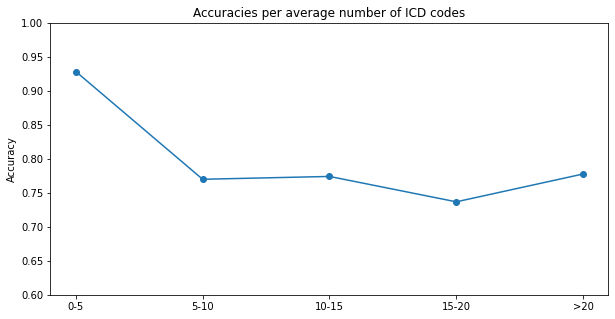

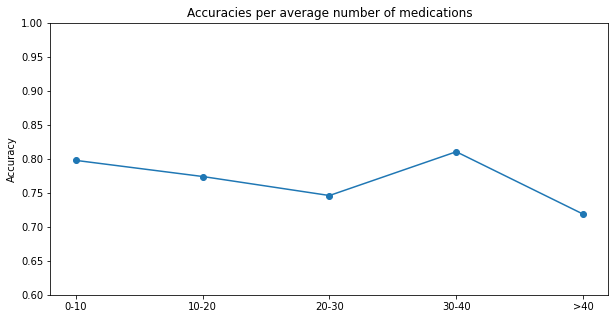

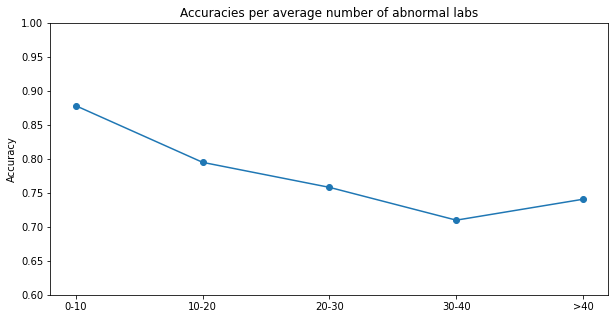

In [121]:
if epoch != 1:
    print('ICD-wise accuracies', [(ICD_wise_corr[i]/ICD_wise_tot[i]) for i in range(len(ICD_wise_corr))])
    print('Meds-wise accuracies', [(meds_wise_corr[i]/meds_wise_tot[i]) for i in range(len(meds_wise_corr))])
    print('Labs-wise accuracies', [(labs_wise_corr[i]/labs_wise_tot[i]) for i in range(len(labs_wise_corr))])

    plt.figure(1, figsize=(10, 5))
    y_ticks = []
    for num in range(len(ICD_wise_corr)):
        y_ticks.append(str(num*5))
    for i in range(len(y_ticks) - 1):
        y_ticks[i] = y_ticks[i] + '-' + y_ticks[i+1]
    y_ticks[-1] = ">" + y_ticks[-1]

    plt.scatter(range(len(ICD_wise_corr)), [(ICD_wise_corr[i]/ICD_wise_tot[i]) for i in range(len(ICD_wise_corr))])
    plt.plot(range(len(ICD_wise_corr)), [(ICD_wise_corr[i]/ICD_wise_tot[i]) for i in range(len(ICD_wise_corr))])
    plt.xticks(range(len(ICD_wise_corr)), y_ticks)
    plt.ylim(0.6,1)
    plt.ylabel('Accuracy')
    plt.title('Accuracies per average number of ICD codes')

    plt.savefig(CAE_PATH+'accuracies_icd.png', dpi = 300)

    plt.figure(2, figsize=(10, 5))
    y_ticks = []
    for num in range(len(meds_wise_corr)):
        y_ticks.append(str(num*10))
    for i in range(len(y_ticks) - 1):
        y_ticks[i] = y_ticks[i] + '-' + y_ticks[i+1]
    y_ticks[-1] = ">" + y_ticks[-1]

    plt.scatter(range(len(meds_wise_corr)), [(meds_wise_corr[i]/meds_wise_tot[i]) for i in range(len(meds_wise_corr))])
    plt.plot(range(len(meds_wise_corr)), [(meds_wise_corr[i]/meds_wise_tot[i]) for i in range(len(meds_wise_corr))])
    plt.xticks(range(len(meds_wise_corr)), y_ticks)
    plt.ylim(0.6,1)
    plt.ylabel('Accuracy')
    plt.title('Accuracies per average number of medications')

    plt.savefig(CAE_PATH+'accuracies_meds.png', dpi = 300)

    plt.figure(3, figsize=(10, 5))
    y_ticks = []
    for num in range(len(labs_wise_corr)):
        y_ticks.append(str(num*10))
    for i in range(len(y_ticks) - 1):
        y_ticks[i] = y_ticks[i] + '-' + y_ticks[i+1]
    y_ticks[-1] = ">" + y_ticks[-1]

    plt.scatter(range(len(labs_wise_corr)), [(labs_wise_corr[i]/labs_wise_tot[i]) for i in range(len(labs_wise_corr))])
    plt.plot(range(len(labs_wise_corr)), [(labs_wise_corr[i]/labs_wise_tot[i]) for i in range(len(labs_wise_corr))])
    plt.xticks(range(len(labs_wise_corr)), y_ticks)
    plt.ylim(0.6,1)
    plt.ylabel('Accuracy')
    plt.title('Accuracies per average number of abnormal labs')

    plt.savefig(CAE_PATH+'accuracies_labs.png', dpi = 300)

pickle.dump(model._modules['emb_icd'].weight.data.numpy().T, open(CAE_PATH+'icd_embedding_weights.npy', 'wb'))



# # Use some plotting library
# if epoch % 10 == 0: 
#     show_plot('inputs', _inputs, True)
#     show_plot('outputs', outputs.data.view(-1), True)
#     show_plot('losses', losses[:epoch] / n_iters)

# # Generate a test
# outputs, hidden = model(inputs, False, 50)
# show_plot('generated', outputs.data.view(-1), True)
